In [1]:
import os
import torch
import torch.version
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip ins tall -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}+"----".html

2.2.2


### Hands on tutorial of Graph Representation Learning

In this lecture, we will go through the following topics
1. Graph structued data in Python
2. GNN package - Pytorch-Geometric introduction
3. Representation in Graphs - node2vec, GCN
4. GNN with downstrean tasks
5. GNN for text classification


In [2]:
import os.path as osp
import torch
import numpy as np

import matplotlib.pyplot as plt
from torch_geometric.nn import Node2Vec
from sklearn.manifold import TSNE

# Graph Representation Learning
The goal of Graph Representation Learning aims at learning **embedding vectors** for each node that preserves the proximity in graphs. <br>
To demonstrate, we make use of the `KarateClud` dataset, as we introduced before.

![](https://i.imgur.com/oQv59aR.png)

In [3]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4
Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [4]:
model = Node2Vec(data.edge_index, embedding_dim=16, 
                 walk_length=10,                        # lenght of rw
                 context_size=10, walks_per_node=80,
                 num_negative_samples=1,
                 p=4,q=1,
                 sparse=True)

In [5]:
loader = model.loader(batch_size=128, shuffle=True)

In [6]:
for idx, (pos_nodes, neg_nodes) in enumerate(loader):
    print(idx, pos_nodes.shape, neg_nodes.shape)

0 torch.Size([2720, 10]) torch.Size([2720, 10])


In [7]:
print(pos_nodes)

tensor([[11,  0, 13,  ..., 32, 30, 32],
        [28, 31, 24,  ..., 13, 33, 13],
        [ 3,  2, 27,  ...,  2,  0,  2],
        ...,
        [ 4,  6,  5,  ...,  0,  1, 19],
        [ 5, 10,  0,  ..., 20, 33, 22],
        [18, 33, 30,  ..., 33, 28, 33]])


In [8]:
# View every node as starting nodes for random walk
torch.unique(pos_nodes[:,0], return_counts=True)

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 tensor([80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
         80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]))

In [9]:
print(neg_nodes)

tensor([[11,  7, 19,  ...,  4, 10, 31],
        [28, 15, 30,  ..., 33, 29,  5],
        [ 3, 19,  0,  ..., 21,  4, 26],
        ...,
        [ 4, 15, 17,  ...,  7,  7, 10],
        [ 5, 14, 18,  ...,  7, 17,  5],
        [18,  6, 21,  ...,  7,  0, 32]])


## Visualization

In [10]:
import networkx as nx 
edge_tuples = [tuple(x) for x in data.edge_index.numpy().transpose()]
G = nx.from_edgelist(edge_tuples)
pos = nx.spring_layout(G, center=[0.5, 0.5])
nx.set_node_attributes(G, pos, 'pos')

[29, 33, 31, 32, 18, 33, 30, 8, 32, 29]


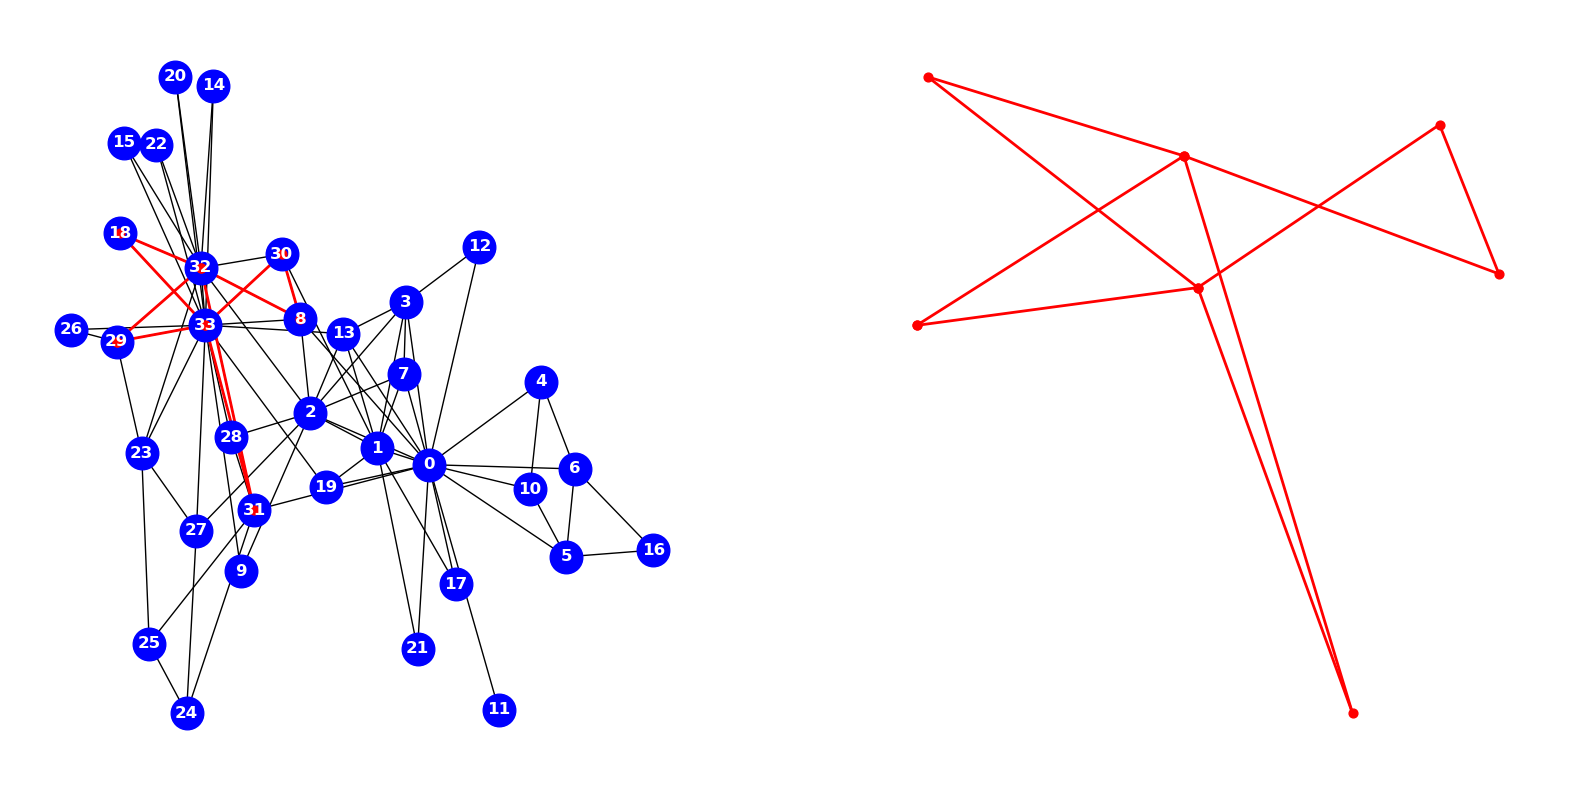

In [11]:
nodelist = next(enumerate(loader))[1][0][0].tolist()
print((nodelist))
walk = nx.path_graph(len(nodelist))
nx.set_node_attributes(walk, {idx: pos[node_id] for idx, node_id in enumerate(nodelist)}, 'pos')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
nx.draw_networkx(G, 
   ax=ax,
   pos=nx.get_node_attributes(G, 'pos'), 
   node_size=550,
   node_color='b',
   font_color="white",
   font_weight='bold'
                )
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 
ax = fig.add_subplot(1, 2, 2)
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 


## Training
Let's create a `Node2vec` model from the `PyG` libiary, which provides the dataloader for creating training instances as well as calculating the objective function. <br>
The objective function is defined as follows

\begin{equation}
L(\Theta) = \log \left ( \sigma (z_u^{\top} z_v)  \right) - \sum_{i=1}^k \log \left ( \sigma (z_u^{\top} z_{n_i})  \right), n_i \sim P_V
\end{equation}

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
node2vec_model = Node2Vec(data.edge_index, embedding_dim=2, walk_length=10,
                 context_size=4, walks_per_node=80,
                 num_negative_samples=5, p=4, q=1, sparse=True).to(device)

loader = node2vec_model.loader(batch_size=128, shuffle=True)
optimizer = torch.optim.SparseAdam(list(node2vec_model.parameters()), lr=0.01)

In [13]:
def train():
    node2vec_model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = node2vec_model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [14]:
for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

Epoch: 01, Loss: 1.9990
Epoch: 02, Loss: 1.9811
Epoch: 03, Loss: 1.9701
Epoch: 04, Loss: 1.9492
Epoch: 05, Loss: 1.9302
Epoch: 06, Loss: 1.9105
Epoch: 07, Loss: 1.8959
Epoch: 08, Loss: 1.8779
Epoch: 09, Loss: 1.8714
Epoch: 10, Loss: 1.8477
Epoch: 11, Loss: 1.8334
Epoch: 12, Loss: 1.8193
Epoch: 13, Loss: 1.8059
Epoch: 14, Loss: 1.7956
Epoch: 15, Loss: 1.7932
Epoch: 16, Loss: 1.7709
Epoch: 17, Loss: 1.7536
Epoch: 18, Loss: 1.7561
Epoch: 19, Loss: 1.7408
Epoch: 20, Loss: 1.7202
Epoch: 21, Loss: 1.7174
Epoch: 22, Loss: 1.6981
Epoch: 23, Loss: 1.7001
Epoch: 24, Loss: 1.6866
Epoch: 25, Loss: 1.6769
Epoch: 26, Loss: 1.6688
Epoch: 27, Loss: 1.6545
Epoch: 28, Loss: 1.6519
Epoch: 29, Loss: 1.6453
Epoch: 30, Loss: 1.6327
Epoch: 31, Loss: 1.6193
Epoch: 32, Loss: 1.6296
Epoch: 33, Loss: 1.6090
Epoch: 34, Loss: 1.6006
Epoch: 35, Loss: 1.5984
Epoch: 36, Loss: 1.5857
Epoch: 37, Loss: 1.5872
Epoch: 38, Loss: 1.5723
Epoch: 39, Loss: 1.5749
Epoch: 40, Loss: 1.5638
Epoch: 41, Loss: 1.5533
Epoch: 42, Loss:

In [15]:
# obtain labels for each nodes
G = nx.karate_club_graph()
labels = np.asarray([G.nodes[i]['club'] != 'Mr. Hi' for i in G.nodes]).astype(np.int64)

# color mapping
mapping = {0:"purple",1:"green"}
node_colors = [mapping[i] for i in labels]

In [16]:
node2vec_model(torch.arange(data.num_nodes, device=device))

tensor([[ 1.1834, -0.8092],
        [ 0.6979,  0.4991],
        [ 0.2818, -0.5522],
        [ 0.6026, -1.1657],
        [ 0.9491, -0.4880],
        [ 1.1219,  0.3009],
        [ 0.2246, -0.4780],
        [-0.1920, -0.7770],
        [ 0.0093,  0.1394],
        [-0.2443,  0.4922],
        [ 0.9756, -0.7203],
        [-1.1608, -1.1568],
        [ 0.4092,  0.0698],
        [ 0.6761,  0.2919],
        [ 1.5770,  1.0012],
        [-0.4967,  0.2736],
        [ 1.0417, -0.1333],
        [ 0.4621, -0.9686],
        [-0.5690,  0.3373],
        [ 0.3249,  0.1765],
        [-0.5556,  0.3340],
        [ 0.4802, -0.1109],
        [-0.3194, -0.3184],
        [-0.3277,  0.4058],
        [-0.8287,  0.1663],
        [-1.2316,  0.2560],
        [ 0.1346,  0.7404],
        [-1.3131, -0.8365],
        [-0.1359, -0.3457],
        [-0.2869,  1.1086],
        [-0.1421,  0.0379],
        [-0.0758,  0.0325],
        [-0.4202, -1.1036],
        [-0.3288,  1.3241]], device='cuda:0', grad_fn=<IndexBackward0>)

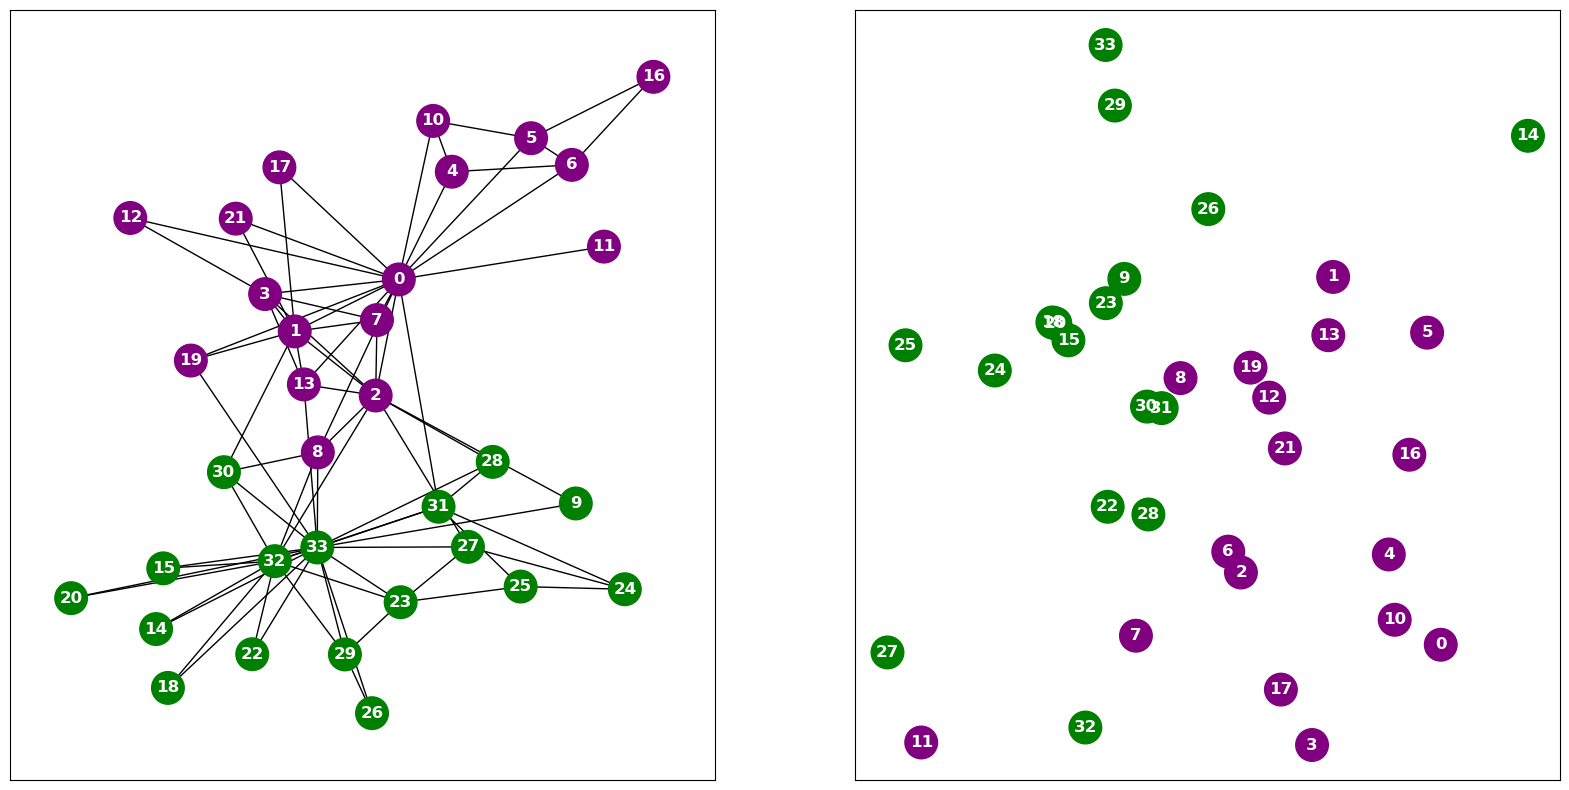

In [17]:
fig = plt.figure(figsize=(20, 10))

# plot the original graph
ax = fig.add_subplot(1, 2, 1)
nx.draw_networkx(G, 
   ax=ax,
   pos = nx.spring_layout(G, center=[0.5, 0.5]), 
   node_size=550,
   node_color=node_colors,
   font_color="white",
   font_weight='bold'
                )

# visualize embedding in 2D space
ax = fig.add_subplot(1, 2, 2)
with torch.no_grad():
    embedding = node2vec_model(torch.arange(data.num_nodes, device=device))
    embedding = embedding.cpu().numpy()
    pos = {i:v for i,v in enumerate(embedding)}

# make plots
nx.draw_networkx_nodes(G, 
   ax=ax,
   pos=pos, 
   node_size=550,
   node_color=node_colors,
)

nx.draw_networkx_labels(
    G,
    pos=pos, 
   font_color="white",
   font_weight='bold',
   )
plt.show()

# Practice: Representation learning on large graphs
<!-- This tutorial will teach you how to apply **Graph Neural Networks (GNNs) to the task of node classification**.
Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*). -->

To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).<br>

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We again can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid)

Another interesting application citation graphs could be found at [connected papers](https://www.connectedpapers.com/).

In [18]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(root='./data', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Processing...
Done!


Overall, this dataset is quite similar to the previously used [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) network.
We can see that the `Cora` network holds 2,708 nodes and 10,556 edges, resulting in an average node degree of 3.9.
For training this dataset, we are given the ground-truth categories of 140 nodes (20 for each class).
This results in a training node label rate of only 5%.

In contrast to `KarateClub`, this graph holds the additional attributes `val_mask` and `test_mask`, which denotes which nodes should be used for validation and testing. We can further see that this network is undirected, and that there exists no isolated nodes (each document has at least one citation).
<!-- Furthermore, we make use of **[data transformations](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-transforms) via `transform=NormalizeFeatures()`**.
Transforms can be used to modify your input data before inputting them into a neural network, *e.g.*, for normalization or data augmentation.
Here, we [row-normalize](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.NormalizeFeatures) the bag-of-words input feature vectors. -->


## Practice: learning node embeddings for each node (document)
1. Please use node2vec to learn embeddings on `Cora` dataset
2. Define your node2vec model configurations
3. Training
4. Vistualization nodes in 2D space. The color of node indicates the "label" of the node. What did you observe in the figure?

In [19]:
# initialize molde
node2vec_model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = node2vec_model.loader(batch_size=128, shuffle=True)
optimizer = torch.optim.SparseAdam(list(node2vec_model.parameters()), lr=0.01)

In [20]:
# training 
for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

Epoch: 01, Loss: 8.0397
Epoch: 02, Loss: 6.0246
Epoch: 03, Loss: 4.9015
Epoch: 04, Loss: 4.1035
Epoch: 05, Loss: 3.4467
Epoch: 06, Loss: 2.9291
Epoch: 07, Loss: 2.5202
Epoch: 08, Loss: 2.1929
Epoch: 09, Loss: 1.9383
Epoch: 10, Loss: 1.7247
Epoch: 11, Loss: 1.5521
Epoch: 12, Loss: 1.4183
Epoch: 13, Loss: 1.3081
Epoch: 14, Loss: 1.2211
Epoch: 15, Loss: 1.1537
Epoch: 16, Loss: 1.0962
Epoch: 17, Loss: 1.0559
Epoch: 18, Loss: 1.0176
Epoch: 19, Loss: 0.9903
Epoch: 20, Loss: 0.9667
Epoch: 21, Loss: 0.9486
Epoch: 22, Loss: 0.9319
Epoch: 23, Loss: 0.9197
Epoch: 24, Loss: 0.9080
Epoch: 25, Loss: 0.8986
Epoch: 26, Loss: 0.8918
Epoch: 27, Loss: 0.8836
Epoch: 28, Loss: 0.8787
Epoch: 29, Loss: 0.8733
Epoch: 30, Loss: 0.8686
Epoch: 31, Loss: 0.8650
Epoch: 32, Loss: 0.8609
Epoch: 33, Loss: 0.8585
Epoch: 34, Loss: 0.8549
Epoch: 35, Loss: 0.8519
Epoch: 36, Loss: 0.8511
Epoch: 37, Loss: 0.8469
Epoch: 38, Loss: 0.8467
Epoch: 39, Loss: 0.8452
Epoch: 40, Loss: 0.8441
Epoch: 41, Loss: 0.8417
Epoch: 42, Loss:

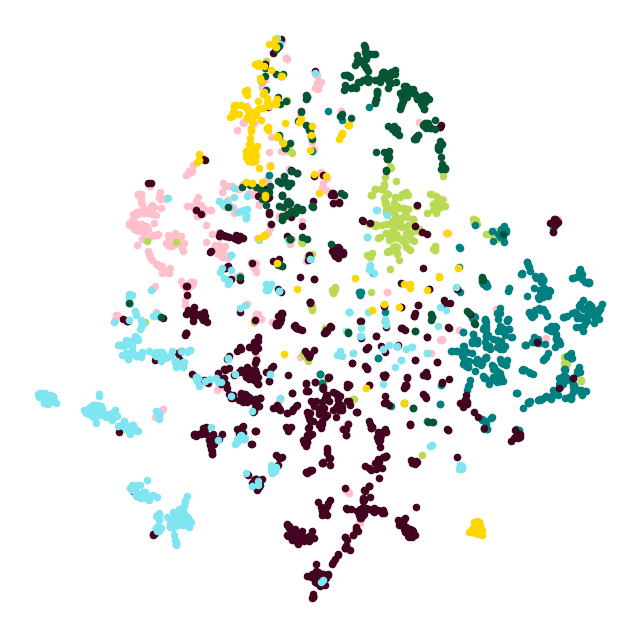

In [21]:
# after your model is learned, run the following scripts and see what you get!
@torch.no_grad()
def plot_points(colors):
    node2vec_model.eval()
    z = node2vec_model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(colors)

# Application of GRL: Semi-supervised document classification
As mentioned previously, `Cora` contains 2K documents of scientific papers. However, **only 5% of documents are given the ground-truth labels** in the training set while the remaining documents are unlabeled.

Since each paper(node) is described by a 1433-dimensional bag-of-words feature vector, let's first build a document classifier and see how it works!

In [22]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)
        return x

In [23]:
model = MLP(hidden_channels=64)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
    model.train()
    optimizer.zero_grad()  
    out = model(data.x)  
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  
    optimizer.step() 
    return loss

for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9480
Epoch: 002, Loss: 1.9403
Epoch: 003, Loss: 1.9278
Epoch: 004, Loss: 1.9117
Epoch: 005, Loss: 1.8924
Epoch: 006, Loss: 1.8694
Epoch: 007, Loss: 1.8424
Epoch: 008, Loss: 1.8110
Epoch: 009, Loss: 1.7752
Epoch: 010, Loss: 1.7350
Epoch: 011, Loss: 1.6904
Epoch: 012, Loss: 1.6415
Epoch: 013, Loss: 1.5883
Epoch: 014, Loss: 1.5310
Epoch: 015, Loss: 1.4700
Epoch: 016, Loss: 1.4055
Epoch: 017, Loss: 1.3381
Epoch: 018, Loss: 1.2683
Epoch: 019, Loss: 1.1968
Epoch: 020, Loss: 1.1242
Epoch: 021, Loss: 1.0514
Epoch: 022, Loss: 0.9792
Epoch: 023, Loss: 0.9084
Epoch: 024, Loss: 0.8397
Epoch: 025, Loss: 0.7740
Epoch: 026, Loss: 0.7119
Epoch: 027, Loss: 0.6537
Epoch: 028, Loss: 0.5999
Epoch: 029, Loss: 0.5505
Epoch: 030, Loss: 0.5058
Epoch: 031, Loss: 0.4655
Epoch: 032, Loss: 0.4295
Epoch: 033, Loss: 0.3975
Epoch: 034, Loss: 0.3693
Epoch: 035, Loss: 0.3446
Epoch: 036, Loss: 0.3229
Epoch: 037, Loss: 0.3039
Epoch: 038, Loss: 0.2874
Epoch: 039, Loss: 0.2730
Epoch: 040, Loss: 0.2603


In [24]:
@torch.no_grad()
def test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5980


## Improving document classification with node embedding
It seems that the MLP model with the Bag-of-Word feature cannot perform well in the semi-supervised scenario.<br>
Can we make use of the graph structure between documents and generate additional features in unsupervised fashion where the unlabeled document could provide some signals for us.

In [25]:
# Here we use a simple Logistic regression classifier for document classification
from sklearn.linear_model import LogisticRegression

In [26]:
with torch.no_grad():
    node2vec_model.eval()
    # the node embedding is actually the document embedding learned from graph structure
    node_embedding = node2vec_model().cpu().numpy() 
    print(node_embedding.shape)

(2708, 128)


In [27]:
# Training
clf = LogisticRegression() # create logistic regression model
clf.fit(node_embedding[data.train_mask,:], data.y[data.train_mask]) # fit on training set

# Testing
test_acc = clf.score(node_embedding[data.test_mask,:], data.y[data.test_mask])
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7100


Wow! We improve the testing accuracy from ~60%(BOW+MLP) to 70% with network embedding(without using the BOW features) !


Can we further improve the performance by considering both **network structure and BOW features simultaneously?**

In [28]:
# training data
train_bow = data.x[data.train_mask].numpy()
train_node_embedding = node_embedding[data.train_mask,:]
train_features = np.hstack([train_bow, train_node_embedding])

# testing data
test_bow = data.x[data.test_mask].numpy()
test_node_embedding = node_embedding[data.test_mask,:]
test_features = np.hstack([test_bow,test_node_embedding])

print("Training feature:",train_features.shape)
print("Testing feature:",test_features.shape)

Training feature: (140, 1561)
Testing feature: (1000, 1561)


In [29]:
# Training
clf = LogisticRegression() # create logistic regression model
clf.fit(train_features, data.y[data.train_mask]) # fit on training set

# Testing
test_acc = clf.score(test_features, data.y[data.test_mask])
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7120


Not looking good...

Don't worry! We will introduce how the state-of-the-art solution: **Graph Neural Network(GNN)** solves this issue in the following topic.

1. Bag of word + MLP with `Accuracy:0.6`
2. Node2vec + Logistic regression with `Accuracy:0.703`
3. Node2vec with Bag of word + Logistic regression with `Accuracy:0.707`